In [1]:
import itertools
import numpy as np
import os
import pandas as pd
import random
import requests
from matplotlib import pyplot as plt
from spotlight.cross_validation import user_based_train_test_split
from spotlight.evaluation import sequence_mrr_score, sequence_precision_recall_score
from spotlight.interactions import Interactions
from spotlight.sequence.implicit import ImplicitSequenceModel
from tqdm import tqdm

random_state = np.random.RandomState(42) # create random state for repeatability

In [2]:
# Load Steam API key from environment variable
API_KEY = os.environ.get('STEAM_API_KEY')
if API_KEY is None:
    print("API_KEY is not set. Please set the environment variable.")
    
APP_ID = '1086940' # appid for Baldur's Gate 3

## Recommending Steam Achievements Using Sequence Models

We consider the family of implicit sequence models available in the <a href="https://maciejkula.github.io/spotlight/sequence/implicit.html">Spotlight</a> library.

In [3]:
def retrieve_game_schema(api_key, app_id):
    # Fetch game information from the schema endpoint
    url = f"http://api.steampowered.com/ISteamUserStats/GetSchemaForGame/v2/?key={api_key}&appid={app_id}&language=english"
    response = requests.get(url)

    if response.status_code == 200:
        return response.json()
    else:
        return None

In [4]:
game_schema = retrieve_game_schema(API_KEY, APP_ID)
df_achievements = pd.DataFrame(game_schema['game']['availableGameStats']['achievements'], columns=['name', 'displayName', 'description'])

In [5]:
df_achievements.head()

,name,displayName,description
0,BG3_Quest01,Descent From Avernus,Take control of the nautiloid and escape the H...
1,BG3_Quest02,The Plot Thickens,NaN
2,BG3_Quest03,The City Awaits,NaN
3,BG3_Quest04,All's Well That Ends Well,NaN
4,BG3_Quest05,Absolute Power Corrupts,NaN


In [6]:
df_interactions = pd.read_csv('./data/buldars_gate_3_achievements_long_2023-11-04.csv', dtype={'steam_id': int, 'timestamp': int})
df_interactions.head()

,steam_id,achievement_name,timestamp
0,76561199004154858,BG3_Quest01,1691436759
1,76561199004154858,BG3_Quest10,1691545351
2,76561199004154858,BG3_Quest11,1691847458
3,76561199004154858,BG3_Quest13,1691450888
4,76561199004154858,BG3_Quest29,1691441756


In [7]:
# Create dictionaries of Steam IDs and achievement names onto internal IDs used by the model
steam_id_dict = {steam_id: idx + 1 for idx, steam_id in enumerate(df_interactions['steam_id'].unique())}
achievement_name_dict = {ach_name: idx + 1 for idx, ach_name in enumerate(df_interactions['achievement_name'].unique())}

### Prepare Sequences from Interactions

In [8]:
df_modified = df_interactions.copy()
# Replace 'steam_id' and 'achievement_name' with integers using the dictionaries
df_modified['steam_id'] = df_modified['steam_id'].map(steam_id_dict)
df_modified['achievement_name'] = df_modified['achievement_name'].map(achievement_name_dict)
df_modified.dropna()
df_modified = df_modified[df_modified['timestamp'] != 0]
df_modified


,steam_id,achievement_name,timestamp
0,1,1,1691436759
1,1,2,1691545351
2,1,3,1691847458
3,1,4,1691450888
4,1,5,1691441756
...,...,...,...
57455,2596,10,1691271021
57456,2596,31,1691320973
57457,2596,22,1694032025
57458,2596,11,1691606533


In [9]:
interactions = Interactions(
    user_ids=df_modified['steam_id'].values.astype(np.int32), # need to convert to int32 for user_based_train_test_split
    item_ids=df_modified['achievement_name'].values.astype(np.int32),
    timestamps=df_modified['timestamp'].values.astype(np.int32)
)

In [10]:
# Split interactions between train, eval and test sets with ratio 0.6:0.2:0.2 based on user ids, 
# so that a given user’s entire interaction history is either in the train, eval or test set.
rest_interactions, test_interactions = user_based_train_test_split(interactions, test_percentage=0.2, random_state=random_state)
train_interactions, eval_interactions = user_based_train_test_split(rest_interactions, test_percentage=0.25, random_state=random_state)

In [11]:
# Convert the interaction sets into sequences
max_sequence_length = len(achievement_name_dict.keys())

def interactions_to_sequences(interactions, max_sequence_length):
    return interactions.to_sequence(max_sequence_length=max_sequence_length, min_sequence_length=None, step_size=None)

rest_sequences, train_sequences, eval_sequences, test_sequences = [
    interactions_to_sequences(interaction_set, max_sequence_length) for interaction_set in [rest_interactions, train_interactions, eval_interactions, test_interactions]
]

all_sequences = interactions_to_sequences(interactions, max_sequence_length)

We plot the distribution of the number of achievements unlocked per player:

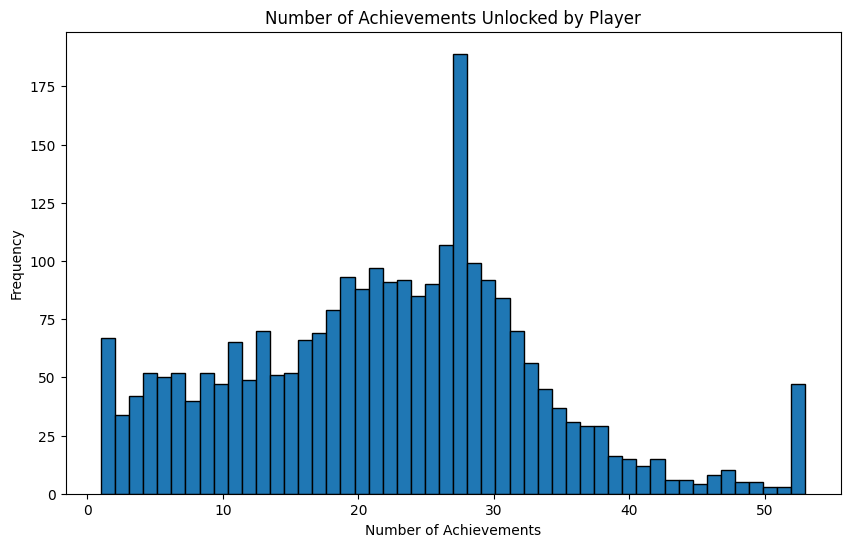

In [12]:
sequence_lengths = np.count_nonzero(all_sequences.sequences, axis=1)
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=50, edgecolor='black')
plt.xlabel('Number of Achievements')
plt.ylabel('Frequency')
plt.title('Number of Achievements Unlocked by Player')
plt.show()

We examine the distribution of intervals between consecutive achivement unlocks.

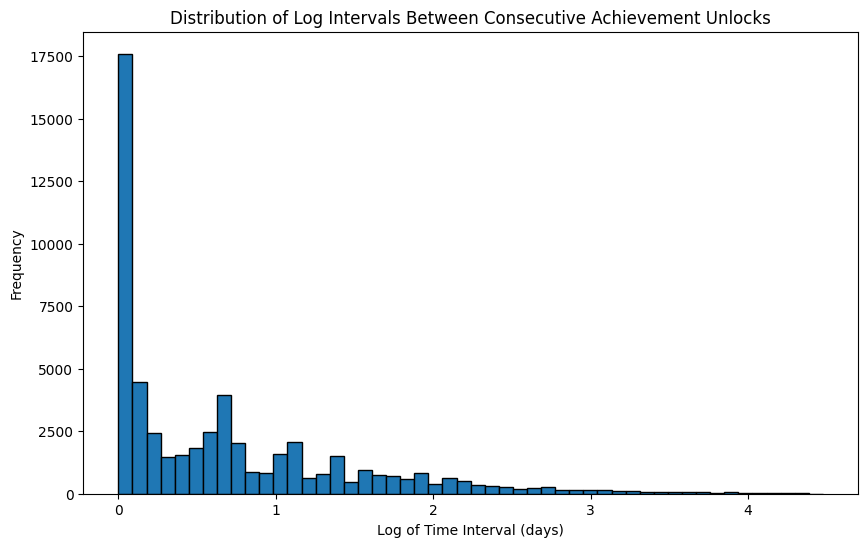

In [13]:
# Check the distribution of intervals between achievement unlocks
df_intervals = df_interactions.copy()
df_intervals.sort_values(by=['steam_id', 'timestamp'], inplace=True)

# Calculate the time differences between consecutive rows for each steam_id
df_intervals['time_diff'] = df_intervals.groupby('steam_id')['timestamp'].diff()
df_intervals['time_diff_seconds'] = df_intervals['time_diff'].astype('timedelta64[s]')

# Convert seconds to days and take the logarithm
df_intervals['log_days'] = np.log1p(df_intervals['time_diff_seconds'].astype('timedelta64[s]').view('float') / (24 * 3600))

# Plot the distribution of log-transformed time differences
plt.figure(figsize=(10, 6))
plt.hist(df_intervals['log_days'].dropna(), bins=50, edgecolor='black')
plt.title('Distribution of Log Intervals Between Consecutive Achievement Unlocks')
plt.xlabel('Log of Time Interval (days)')
plt.ylabel('Frequency')
plt.show()

In [14]:
df_intervals.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
steam_id,57460.0,76561198255625184.0,358200725.924441,76561197960455536.0,76561198037585008.0,76561198101764240.0,76561198292677152.0,76561199564403936.0
timestamp,57460.0,1695091605.507884,2433149.514333,1691079080.0,1692837280.25,1695160278.5,1697392578.0,1699091481.0
time_diff,54864.0,185611.949457,465818.90143,0.0,4166.0,48270.0,167247.25,7507612.0
time_diff_seconds,54864,2 days 03:33:31.949456838,5 days 09:23:38.901430090,0 days 00:00:00,0 days 01:09:26,0 days 13:24:30,1 days 22:27:27.250000,86 days 21:26:52
log_days,54864.0,0.68457,0.791202,0.0,0.047091,0.44384,1.076957,4.476128


### Grid Search of Implicit Sequence Model Params

We evaluate the mean_mrr, precision_at_1 and recall_at_1 of different loss functions and sequence representations.

In [15]:
def train_evaluate_model(param_grid, train_sequences, test_sequences, random_state_seed=42):
    random_state = np.random.RandomState(random_state_seed)
    
    # Generate all combinations of parameters
    param_combinations = list(itertools.product(*param_grid.values()))
    
    results = []

    # Use tqdm to add a progress bar
    for params in tqdm(param_combinations, desc="Grid Search Progress"):
        # Create model with current set of parameters
        model = ImplicitSequenceModel(
            loss=params[0],
            representation=params[1],
            embedding_dim=32,
            n_iter=10,
            batch_size=256,
            l2=0.0,
            learning_rate=0.01,
            random_state=random_state
        )

        # Train the model
        model.fit(train_sequences, verbose=False)

        # Evaluate the model
        user_mrr_scores = sequence_mrr_score(model, test_sequences, exclude_preceding=True)
        precision_recall_scores = sequence_precision_recall_score(model, test_sequences, k=1, exclude_preceding=True)

        # Store the results
        result = {
            'loss': params[0],
            'representation': params[1],
            'mrr_mean': user_mrr_scores.mean(),
            'precision_mean': precision_recall_scores[0].mean(),
            'recall_mean': precision_recall_scores[1].mean()
        }
        results.append(result)

    return results

In [16]:
param_grid = {
    'loss': ['pointwise', 'bpr', 'hinge', 'adaptive_hinge'],
    'representation': ['pooling', 'cnn', 'lstm', 'mixture']
}

In [17]:
results = train_evaluate_model(param_grid, train_sequences, eval_sequences)

Grid Search Progress: 100%|██████████| 16/16 [00:58<00:00,  3.69s/it]


In [18]:
df_results = pd.DataFrame(results)

In [19]:
df_results.sort_values(by='mrr_mean', ascending=False)

,loss,representation,mrr_mean,precision_mean,recall_mean
14,adaptive_hinge,lstm,0.496594,0.359528,0.359528
9,hinge,cnn,0.489683,0.341847,0.341847
13,adaptive_hinge,cnn,0.484544,0.345776,0.345776
15,adaptive_hinge,mixture,0.458416,0.318271,0.318271
10,hinge,lstm,0.432601,0.271120,0.271120
5,bpr,cnn,0.430152,0.253438,0.253438
11,hinge,mixture,0.429247,0.265226,0.265226
4,bpr,pooling,0.358842,0.180747,0.180747
8,hinge,pooling,0.351494,0.192534,0.192534
6,bpr,lstm,0.335876,0.168959,0.168959


### Test Implicit Sequence Model

Test a model with `adaptive_hinge` loss and `lstm` representation on the test dataset.

In [20]:
loss = 'adaptive_hinge'
representation = 'lstm'

model = ImplicitSequenceModel(
    loss=loss,
    representation=representation,
    embedding_dim=32,
    n_iter=10,
    batch_size=256,
    l2=0.0,
    learning_rate=0.01,
    random_state=random_state
)

In [21]:
# Train model on rest_sequences (i.e. on train and eval datasets combined)
model.fit(rest_sequences, verbose=False)

In [22]:
# Compute mean reciprocal rank (MRR) scores. Each sequence in test is split into two parts: 
# the first part, containing all but the last elements, is used to predict the last element.
# The reciprocal rank of the last element is returned for each sequence.
user_mrr_scores = sequence_mrr_score(model, test_sequences, exclude_preceding=True)
mrr_score = user_mrr_scores.mean()
print(f'MRR Score of {loss} loss, {representation} representation model: {mrr_score:.2f}')

MRR Score of adaptive_hinge loss, lstm representation model: 0.48


In [23]:
# Compute sequence precision and recall scores. 
# Each sequence in test is split into two parts: 
# the first part, containing all but the last k elements, is used to predict the last k elements.
precision_recall_scores = sequence_precision_recall_score(model, train_sequences, k=1, exclude_preceding=True)
precision_recall_scores[0].mean(), precision_recall_scores[1].mean()

(0.36246786632390743, 0.36246786632390743)

How does this performance compare to that of randomly picking one of the remaining available achievements, or simply picking the next most popular achievement?

In [24]:
# Get the possible achievements, i.e. for each player remove all achievements (except their most recent) from the game's full achievement set
possible_achievements = [list(set(achievement_name_dict.values()) - set(np.trim_zeros(sequence[:-1]))) for sequence in all_sequences.sequences]

# Randomize the order of the possible achievements for each player
for inner_list in possible_achievements:
    random.shuffle(inner_list)
possible_achievements

random_mrr_scores = [1 / (possible_achievements[i].index(sequence[-1]) + 1) for i, sequence in enumerate(all_sequences.sequences)]
random_mrr = np.mean(random_mrr_scores)

print(f'MRR Score of randomly ranking possible achievements: {random_mrr:.2f}')

MRR Score of randomly ranking possible achievements: 0.15


In [25]:
achievement_counts = df_interactions['achievement_name'].value_counts()

# Create a list of achievement names ordered by popularity
ordered_achievements = achievement_counts.index.map(achievement_name_dict).tolist()

ordered_possible_achievements = [
    sorted(sublist, key=lambda x: ordered_achievements.index(x)) for sublist in possible_achievements
]

ordered_mrr_scores = [1 / (ordered_possible_achievements[i].index(sequence[-1]) + 1) for i, sequence in enumerate(all_sequences.sequences)]
ordered_mrr = np.mean(ordered_mrr_scores)

print(f'MRR Score of popularity ranking possible achievements: {ordered_mrr:.2f}')

MRR Score of popularity ranking possible achievements: 0.34


We see that our sequence model performs better than random chance and recommending achievements based on popularity!

In [26]:
def get_ranked_scores_for_user(model, user_sequence, achievement_name_dict, exclude_last_item=True):
    # Items the user has already interacted with
    user_items = np.trim_zeros(user_sequence, 'f')
    # Items not in the users set that we want to retrieve scores for
    if exclude_last_item:
        desired_items = [key for key, value in achievement_name_dict.items() if value not in user_items[:-1]]
    else:
        desired_items = [key for key, value in achievement_name_dict.items() if value not in user_items[:]]

    scores = model.predict(sequences=user_sequence)
    scores_series = pd.Series(scores[1:], index=achievement_name_dict.keys(), name='ScoresSeries')
    scores_series = scores_series.loc[desired_items]
    scores_series = scores_series.sort_values(ascending=False)

    return scores_series

In [27]:
# Retrieve the ranked scores 
scores_series = get_ranked_scores_for_user(model, test_sequences.sequences[0], achievement_name_dict)
pd.merge(scores_series, df_achievements, right_on='name', left_index=True, how='left').rename(columns={'ScoresSeries': 'score'}).head(10)

,score,name,displayName,description
8,1.969900,BG3_Quest09,Roleplayer,Complete ten background goals in a single play...
11,1.204656,BG3_Quest12,Dig for Victory,Dig up five buried chests in a single playthro...
1,1.003675,BG3_Quest02,The Plot Thickens,NaN
45,0.818080,BG3_Quest46,Repairing the Weave,NaN
32,0.748165,BG3_Quest33,A Grym Fate,NaN
40,0.741106,BG3_Quest41,Bottoms Up,Long Rest using only alcohol - a time-honoured...
42,0.693325,BG3_Quest43,Bookworm,Read 100 different books in a single playthrou...
16,0.620013,BG3_Quest17,Homebrewer,Create three unique alchemical solutions in a ...
17,0.611072,BG3_Quest18,You Have Two Hands for a Reason,NaN
19,0.550706,BG3_Quest20,Forged in Blood and Fire,NaN


In [28]:
# Get the achievement names for a given user sequence, preserving sequence order
achievement_names_list = [key for item_number in np.trim_zeros(test_sequences.sequences[0], 'f') for key, value in achievement_name_dict.items() if value == item_number]
achievement_names_list

['BG3_Quest01',
 'BG3_Quest29',
 'BG3_Quest13',
 'BG3_Quest50',
 'BG3_Quest42',
 'BG3_Quest10',
 'BG3_Quest32',
 'BG3_Quest45',
 'BG3_Quest11',
 'BG3_Quest30',
 'BG3_Quest31']

### Markov Model

How does this compare to a Markov model which recommends the achievement which was most frequently unlocked after the player's last achievement?

In [63]:
# Build a transition matrix for the Markov model:
def build_transition_matrix(train_sequences, num_achievements):
    # Initialize a transition matrix with zeros
    transition_matrix = np.zeros((num_achievements+1, num_achievements+1))

    # Count transitions in the training sequences
    for sequence in train_sequences:
        # Remove leading zeros and keep unique elements
        sequence = np.concatenate(([0], np.trim_zeros(sequence, 'f')))

        for i in range(len(sequence) - 1):
            current_state = sequence[i]
            next_state = sequence[i + 1]

            # Check if current_state and next_state are within the bounds
            if 0 <= current_state < num_achievements and 0 <= next_state < num_achievements:
                transition_matrix[current_state, next_state] += 1
            else:
                pass
                # print(f"Ignored out-of-bounds transition: {current_state} -> {next_state}")

    # Normalize the rows to get probabilities
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    transition_matrix = transition_matrix / row_sums
    transition_matrix = np.nan_to_num(transition_matrix, nan=0.0)

    return transition_matrix

def predict_next_achievements(transition_matrix, current_achievement):
    # Check if current_achievement is within the bounds
    if 0 <= current_achievement < transition_matrix.shape[0]:
        probabilities = transition_matrix[current_achievement, :]
        next_achievements = np.argsort(probabilities)[::-1]
        return next_achievements
    else:
        return None  # Indicate that the current achievement is out of bounds

def precision_recall_at_k(user_sequence, predicted_achievements, true_next_achievement, k):
    # Keep only the top-k predicted achievements
    top_k_predictions = predicted_achievements[:k]

    # Compute precision at k
    precision_at_k = len(np.intersect1d(top_k_predictions, [true_next_achievement])) / k

    # Compute recall at k
    recall_at_k = len(np.intersect1d(top_k_predictions, [true_next_achievement])) / len(user_sequence)

    return precision_at_k, recall_at_k

def compute_mrr(predicted_achievements, true_next_achievement):
    return 1 / (np.where(predicted_achievements == true_next_achievement)[0] + 1)

# Return mean mrr, precision at k and recall at k scores for the Markov model
def evaluate_markov_model(transition_matrix, test_sequences, k=1):
    mrr_scores = []
    precision_scores = []
    recall_scores = []

    for user_sequence in test_sequences:
        # Remove leading zeros and keep unique elements
        user_sequence = np.concatenate(([0], np.trim_zeros(user_sequence, 'f')))
        current_achievement = user_sequence[-2]
        true_next_achievement = user_sequence[-1]

        # Predict the next achievement using the transition matrix
        predicted_achievements = predict_next_achievements(transition_matrix, current_achievement)

        # Check if predicted_achievement is not None (within bounds)
        if predicted_achievements is not None:
            # Evaluate MRR
            mrr_score = compute_mrr(predicted_achievements, true_next_achievement)
            if mrr_score is not None:
                mrr_scores.append(mrr_score)

            # Evaluate precision and recall at k
            precision_at_k, recall_at_k = precision_recall_at_k(user_sequence, predicted_achievements, true_next_achievement, k)
            precision_scores.append(precision_at_k)
            recall_scores.append(recall_at_k)

    return np.mean(mrr_scores), np.mean(precision_scores), np.mean(recall_scores)

In [64]:
# Number of unique achievements
num_achievements = len(achievement_name_dict.values())

# Build the transition matrix
transition_matrix = build_transition_matrix(train_sequences.sequences, num_achievements)

# Evaluate the Markov model
mrr, precision, recall = evaluate_markov_model(transition_matrix, test_sequences.sequences, k=1)

print(f"MRR: {mrr}")
print(f"Precision at 1: {precision}")
print(f"Recall at 1: {recall}")

MRR: 0.34227076116834404
Precision at 1: 0.22033898305084745
Recall at 1: 0.0173758452813858


/tmp/ipykernel_259654/1381715371.py:24: RuntimeWarning: invalid value encountered in divide
  transition_matrix = transition_matrix / row_sums
